In [ ]:
import numpy as np
import math
import os
import time
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import imread
from scipy.signal import fftconvolve
from skimage.feature import peak_local_max
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
import pandas as pd
from skimage import data, img_as_float
from scipy import ndimage

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from correlation import *
from utils import read_tiff, scan_directory_tree, update_slice, make_dir

In [4]:
root_path = u'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\'

datasets = scan_directory_tree(root_path)

Start scanning
End scanning
In total 116 datasets


In [5]:
path = datasets[0]
print(path)
#print(re.search(r'Ansicht[ ][0-9][°]', path))

#for d in datasets:
    #res = re.findall(r'[0-9]+°C', d)
    #res = r.group()[:-1] if r else 'Ansicht ?'
    

    
    #print(res[0:2], ' ', res[2:4])
    #print(datasets.index(d))
    
# Parse data catalog
days     = list(map(lambda p: re.search(r'([0-9.]+[ ]auf[ ][0-9.]+)', p).group().replace(' auf ', '-'), datasets))
sample   = list(map(lambda p: re.search(r'([0-9]+[_][0-9][\\])', p).group()[:-1], datasets))
view     = list(map(lambda p: re.search(r'Ansicht[ ][0-9]+[°]', p).group()[:-1] if re.search(r'Ansicht[ ][0-9]+[°]', p) else 'Ansicht ?', datasets))
op       = list(map(lambda p: re.search(r'OP_[0-9,]+bar', p).group()[3:], datasets))
temp1    = list(map(lambda p: re.findall(r'[0-9]+°C', p)[0], datasets))
pressure = list(map(lambda p: re.search(r'[12][05][0]bar', p).group()[:-3], datasets))
temp2    = list(map(lambda p: re.findall(r'[0-9]+°C', p)[1], datasets))
region   = list(map(lambda p: re.search(r'([Z][0-9.]+[Y][0-9.]+)', p).group()[:], datasets))
datapath = list(map(lambda p: '\\'.join(p.split('\\')[:][:-1]), datasets))
filename = list(map(lambda p: p.split('\\')[-1:][0].replace(u"\xb0", "")[:-5] + '.tif', datasets))

#print(file_name)
#print(len(file_name))

y:\projects\pn-reduction\2018_03_esrf_mi1325\Phantom\Glasduese\Nachtschicht 11.3 auf 12.3\025_3\Ansicht off\OP_1bar_25°C_100bar_25°C\Z0Y0\OP_1bar_25°C_100bar_25°C.cine


In [6]:
df = pd.DataFrame({ 'days'    : days,
                    'geometry': sample,
                     'view'   : view ,
                     'op'     : op,
                     'temp1'  : temp1,
                     'press'  : pressure,
                     'temp2'  : temp2,
                     'region' : region,
                     'file'   : filename,
                     'path'   : datapath                   
                  })


#writer = pd.ExcelWriter('esrf_march_glasduese_datasets.xlsx')
#df.to_excel(writer,'09-12 March 2018 - Glasdüse')
#writer.save()


PermissionError: [Errno 13] Permission denied: 'esrf_march_glasduese_datasets.xlsx'

In [23]:
# all datasets, without path info
#print(df[df.columns[:-2]])

#print(df[df.geometry == '025_1'][df.columns[:-2]])

# all dataset with pressure = 200bar
#print(df[df.press == '200'][df.columns[:-2]])

print('')
# multiple queries
#print(df[(df.press == '200') & (df.region == 'Z0Y0')][df.columns[:-2]])

seq_0_25_position = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.press == '100') &
         (df.op == '1bar')]

print('Position datasets')
print(seq_0_25_position[df.columns[:-2]], '\n')

seq_0_25_pressures = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.temp2 == '25°C') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]

print('Pressures datasets')
print(seq_0_25_pressures[df.columns[:-2]])


seq_0_25_fixed = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]

seq_0_23_fixed = df[(df.geometry == '023_1') &
         (df.days == '09.3-10.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]


print('---------------------------------')
print('Dataset for processing')
print('---------------------------------')

#result = pd.concat([seq_0_25_position, seq_0_25_pressures]).drop_duplicates()
result = pd.concat([seq_0_25_fixed, seq_0_23_fixed]).drop_duplicates()


print(result[df.columns[:-2]])

datasets_path_file_list = []

for i in range(len(result)):
    datasets_path_file_list.append((result.path.iloc[i], result.file.iloc[i]))
    
# Save datasets    
#import pickle
#with open('datasets_list', 'wb') as fp:
#    pickle.dump(datasets_path_file_list, fp)

#print(df[df.region == 'Z5Y0'][df.columns[:-2]])
#grp = df[df.columns[:-2]].groupby(['sample','view'])
#print(list(grp))


Position datasets
        days geometry       view    op temp1 press temp2  region
5  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
6  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
7  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0 

Pressures datasets
         days geometry       view    op temp1 press temp2 region
7   11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C   Z0Y0
10  11.3-12.3    025_1  Ansicht 0  1bar  25°C   200  25°C   Z0Y0
13  11.3-12.3    025_1  Ansicht 0  1bar  25°C   150  25°C   Z0Y0
---------------------------------
Dataset for processing
---------------------------------
         days geometry       view    op temp1 press temp2 region
7   11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C   Z0Y0
34  09.3-10.3    023_1  Ansicht 0  1bar  25°C   100  25°C   Z0Y0


In [5]:
#----------------------------------------
# Select dataset for processing
#----------------------------------------
#path = result.iloc[0].path + '\\'
#file_name = result.iloc[0].file


#path = 'e:\\Data\\spray\\correlation\\025_1\\'
#file_name = 'OP_1bar_25C_100bar_25C.tif'

#path = 'e:\\Data\\spray\\correlation\\003_1\\OP_1bar_25C_100bar_25C_Z0Y0\\'
#file_name = 'frame01.tif'

#path = 'e:\\Data\\spray\\correlation\\seq_full.tif'

#path = datasets[4]

# Test flat correction

dataset = '025_1'
region = ''

#path = '/Users/aleksejersov/data/spray/'+ dataset +'/'
path = 'e:\\Data\\spray\\correlation\\'+ dataset +'\\'
file_name = 'OP_1bar_25C_100bar_25C.tif'
   
#path = u'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 11.3 auf 12.3\\025_3\\Ansicht off\\OP_1bar_25°C_100bar_25°C\\Z0Y0\\OP_1bar_25°C_100bar_25°C.cine'
#print type(path)

# Coorect file name
#pattern = u"\xb0" # degree character '°'
#orig_name = path.split('\\')[-1:][0]
#file_name = path.split('\\')[-1:][0].replace(u"\xb0", "")[:-5] + '.tif'
#path = path.replace(orig_name, file_name)

print('Data path:', path)
print('Data file name:', file_name)

Data path: e:\Data\spray\correlation\025_1\
Data file name: OP_1bar_25C_100bar_25C.tif


In [6]:

max_read_images = 200 # all: 2880
    
start = time()
images = read_tiff(path + file_name, max_read_images)
end = time()

print ('Time elapsed: ', (end-start))

Reading multi-tiff file
Finished reading
Time elapsed:  0.5950593948364258


In [7]:
print(images.shape)

#data = images
value = 22
#value = len(data)/2

interact(update_slice, images_list=fixed(images), sliceN=widgets.IntSlider(min=0,max=len(images)-1,step=1,value=value));


(200, 512, 1024)


interactive(children=(IntSlider(value=22, description='sliceN', max=199), Output()), _dom_classes=('widget-int…

In [ ]:
# Adaptive flat field correction

# Get all flats

flats = []

start_indexes = [21, 301, 582, 862, 1143, 1423, 1703, 1983, 2263, 2543, 2823]




In [14]:
from scipy.ndimage.filters import uniform_filter, gaussian_filter

w = images.shape[2]
h = images.shape[1]

rows = range(80, 80+100)
cols = range(330, 330+100)
patch_empty = np.ix_(rows, cols)


rows = range(80, 120)
cols = range(1000, 1010)
patch_shutter = np.ix_(rows, cols)

rows = range(int(h/2 - h/6), int(h/2 + h/6))
cols = range(int(w/2 - w/6 - 50), int(w/2 + w/6 -50))
patch_spray = np.ix_(rows, cols)


debug = False


if debug:
    frame = 0

    plt.imshow(images[frame][patch_shutter], cmap='gray')
    plt.colorbar()
    plt.show()

    plt.imshow(images[frame][patch_empty], cmap='gray')
    plt.show()

    plt.imshow(images[frame][patch_spray], cmap='gray')
    plt.show()




In [82]:
start_indexes, end_indexes = get_spraying_events(images, max_read_images-1, sigma=15, min_brigthness=15, range_diff_value=0.3)
    
print('OK')
print('Spray events', len(start_indexes))
print(start_indexes)
print(end_indexes)
print('Durations', np.array(end_indexes) - np.array(start_indexes))


OK
Spray events 11
[22, 302, 582, 862, 1143, 1422, 1703, 1960, 2263, 2532, 2824]
[98, 384, 668, 938, 1219, 1499, 1784, 2066, 2343, 2625, 2879]
Durations [ 76  82  86  76  76  77  81 106  80  93  55]


In [56]:
shot_events = [0, 1, 2]

frames = []
batch_size = 40
every_nth = 1

for i in shot_events:
    start = start_indexes[i]
    end = end_indexes[i]
    c = int((end - start) / 2)
    print(c)
    frames.extend(list(range(c-int(batch_size/2), c+int(batch_size/2), every_nth)))
    
print(frames)

49
57
55
[29, 34, 39, 44, 49, 54, 59, 64, 37, 42, 47, 52, 57, 62, 67, 72, 35, 40, 45, 50, 55, 60, 65, 70]


In [13]:
#plt.plot(abs(np.array(diff0_1) - np.array(diff2_3)))
#plt.plot(res_range_empty)
#plt.plot(res_range_spray)
#plt.show()
#
#plt.plot((np.array(res_range_spray) - np.array(res_range_empty)) /  np.array(res_range_spray))
#plt.show()
#
#plt.plot(res_mean_dark)
#plt.show()
#

In [57]:

# top directory for processing results
path_proc = 'proc'

path_raw = proc +    '\\raw'
path_input = proc +  '\\input'
path_amp = proc +    '\\amp'
path_flow_x = proc + '\\flow_x'
path_flow_y = proc + '\\flow_y'
path_corr = proc + '\\corr'

#make_dir(path + path_raw)
#make_dir(path + path_input)
#make_dir(path + path_amp)
#make_dir(path + path_flow_x)
#make_dir(path + path_flow_y)
#make_dir(path + path_corr)
#

Flat field


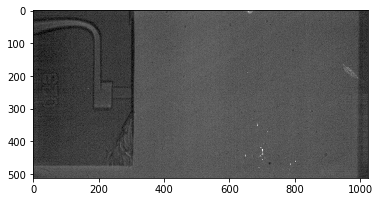

Flat-corrected image


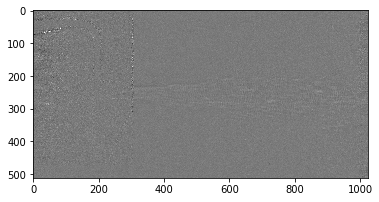

In [59]:
frame = 30

#----------------------------------------
# Make flat field correction
#----------------------------------------

flat_correction = True
flat_automated = True

if flat_correction:
    
    # Automatically Select flat field
    if flat_automated:
        # current sequence event
        seq_num = 0

        # get flats (first frame indicated by start_indexes)
        flats = images[0: start_indexes[seq_num]-1]
        raw = images[frame]

        # avarage flats
        flat = np.mean(flats, axis=0)
     
        im = np.log((flat.astype(float)  + 0.001) / (raw.astype(float)  + 0.001))
        
        im_corr = Image.fromarray(im)
        im_corr.save(path + str(frame) + '_flat_corr.tif')
        
        

        print('Flat field')
        plt.imshow(flat, cmap='gray')
        plt.show()
    
    # Manually Select flat field
    else:
        
        #frame = 'frame01'
        #raw = imread(path + frame + '.tif')
        raw = images[frame]
        flat = imread(path + 'flat.tif')
        #raw = imread(path + 'frame2.tif') # testing sample from 'correlation' folder
        #flat = imread(path + 'flat2.tif')
        im = np.log((flat.astype(float)  + 0.001) / (raw.astype(float)  + 0.001))
        im_corr = Image.fromarray(im)
        im_corr.save(path + str(frame) + '_flat_corr.tif')
        
        
    

else:
    im = imread(path + 'frame01.tif')

print('Flat-corrected image')
plt.imshow(im, vmin=-1.5, vmax=1.5, cmap='gray')
#lt.colorbar()
plt.show()


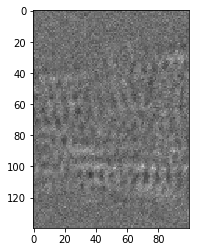

Computing flow
Finished
Time elapsed:  12.707643032073975


In [60]:
window_size = 30

from correlation import crop, compute_flow, compute_flow_area
# Crop frame
xmin = 250
xmax = 950
ymin = 50
ymax = 450

# Centeral path
xmin = 500
xmax = 600
ymin = 180
ymax = 320

plt.imshow(im[ymin:ymax, xmin:xmax], vmin=-0.5, vmax=0.5, cmap='gray')
plt.show()


# Compute cropped region
amp, vx, vy, corr = compute_flow_area(im, window_size, xmin, xmax, ymin, ymax)

# Compute full frame
#amp, vx, vy, errors, corr = compute_flow_area(im, int(window_size), int(window_size / 2), int(im.shape[1] - window_size / 2) , int(window_size / 2), int(im.shape[0] - window_size / 2))


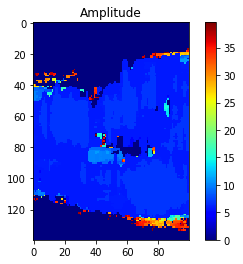

In [61]:
plt.imshow(amp, cmap='jet')
plt.title('Amplitude')
plt.colorbar()
plt.show()

im_res = Image.fromarray(amp)
im_res.save(path + str(frame) +'_res_amp_w_'+str(window_size)+'.tif')

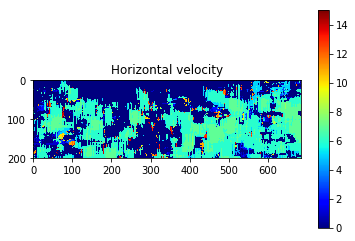

In [51]:
plt.imshow(vx, cmap='jet')
plt.title('Horizontal velocity')
plt.colorbar()
plt.show()

im_res = Image.fromarray(vx)
im_res.save(path + str(frame) + '_res_x_w_'+str(window_size)+'.tif')

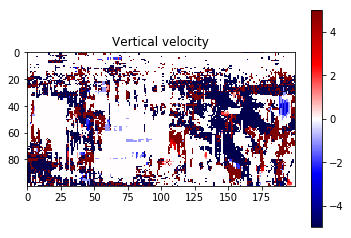

In [19]:
plt.imshow(vy, vmin=-5, vmax=5, cmap='seismic')
plt.title('Vertical velocity')
plt.colorbar()
plt.show()

In [7]:
#plt.imshow(errors, cmap='gray')
#plt.show()

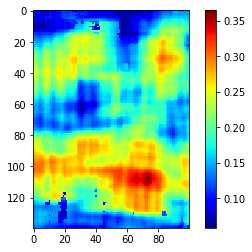

In [35]:
plt.imshow(corr, cmap='jet')
plt.colorbar()
plt.show()

im_res = Image.fromarray(corr)
im_res.save(path + str(frame) + '_res_corr_w_'+str(window_size)+'.tif')

In [9]:
print 'Errors:', np.sum(errors)

Errors: 0.0


C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if sys.path[0] == '':


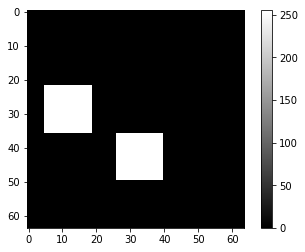

In [5]:
debug = True

if debug:
    
    w=30
    
    # loc = (y, x)
    loc6 = (225 + int(w/2), 320 + int(w/2)) # out
    #loc6 = (466, 724) # out

    
    a = imread("e:\\Data\\spray\\correlation\\" + 'square2.tif')
    #a = crop(im, loc6, w)

    plt.imshow(a, cmap='gray')
    plt.colorbar()
    plt.show()

In [16]:
def make_squares():
    im = np.zeros((30,30))

    cx = int(im.shape[1] / 2)
    cy = int(im.shape[0] / 2)

    w = 3

    shiftx = 10
    shifty = 5

    im[cy-w:cy+w, cx-w: cx+w] = 255
    im[cy-w+shifty:cy+w+shifty, cx-w+shiftx: cx+w+shiftx] = 255

    #im[cy-w-20:cy+w-30, cx-w+10: cx+w+10] = 255

    im +=np.random.normal(2*im+2,60)

    plt.imshow(im, cmap='gray')
    
    return im

    

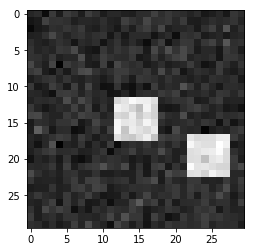

In [17]:
im = make_squares()

(9,)


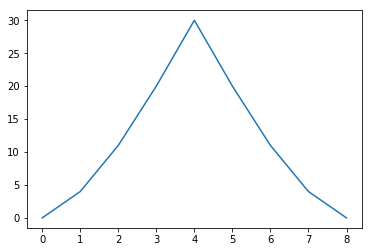

[ 0.00000000e+00  3.86666667e+00  1.06333333e+01  1.93333333e+01
  2.90000000e+01  1.93333333e+01  1.06333333e+01  3.86666667e+00
 -5.26327952e-17]


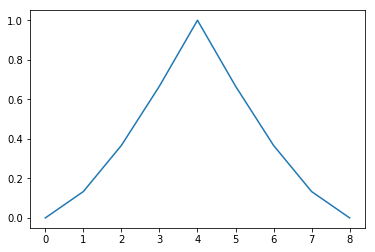

In [3]:
x = np.array([0,1,2,3,4])
my_corr = my_correlation_1d(x, show=True)

corr = fftconvolve(x, x[::-1], mode='full') / np.sum(x ** 2)
plt.plot(corr)

print(my_corr - corr)

In [22]:
debug = True

In [23]:
max_read_images = 200 # all: 2880
    
start = time()
images = read_tiff('e:\\Data\\spray\\correlation\\025_1_no_trans_w15\\input.tif', max_read_images)

amp_w15 = read_tiff('e:\\Data\\spray\\correlation\\025_1_no_trans_w15\\025_1_no_trans_w15_Z0_amp_seq.tif', max_read_images)
amp_w30 = read_tiff('e:\\Data\\spray\\correlation\\025_1_no_trans\\025_1_no_trans_Z0_amp_seq.tif', max_read_images)

end = time()

print ('Time elapsed: ', (end-start))

Reading multi-tiff file
Finished reading
Reading multi-tiff file
Finished reading
Reading multi-tiff file
Finished reading
Time elapsed:  11.884000062942505


In [25]:
#------------------------------------------------------
# Correlation and Find peaks
#------------------------------------------------------

# My peaks finding procedure
#inds, values = my_find_peaks(my_corr, min_distance=2, peak_threshold=0.01, show=True)

#print(values)

def find_correlation(imx):

    
    #imx = gaussian_filter(imx, 1.0)
    
    # My correlation procedure
    #my_corr = my_correlation3(a, show=True)

    #x = np.ones_like(a)
    #norm = fftconvolve(x, x[::-1, ::-1], mode='full') 
    corr = fftconvolve(imx, imx[::-1, ::-1], mode='full') / np.sum(a ** 2)

    #plt.imshow(corr, cmap='jet')
    #plt.colorbar()
    #plt.show()
    
    
    #corr = gaussian_filter(corr, 1.0)
    
    maxima_ind = peak_local_max(corr, min_distance=2, num_peaks=7)
    maxima = sorted(corr[maxima_ind[:,0], maxima_ind[:,1]])
    
    print('')
    print('')

    print('# local peaks', len(maxima))
    #print('Peaks indexes: \n', maxima_ind)

    print (maxima)

    if (len(maxima) == 1):
        print('Warning: One peak!')
        plt.imshow(corr, cmap='jet')
        plt.show()
        return

    v1 = maxima[-2]
    v2 = maxima[-3]

    print('Peaks:', v1, v2)

    # select indexes of two peaks
    index1 = np.where(corr == v1)

    #print index1
    # when both maxima are equal
    #print len(index1)
    if len(index1[0]) > 1:
        index2 = [index1[0][0], index1[1][0]] 
        index1 = [index1[0][1], index1[1][1]] 
    else:
        index2 = np.where(corr == v2)

    # movement to the right
    if index1[1] > corr.shape[1] / 2.0:
        index = index1
    else:
        index = index2

    #print('Index:', index )

    x, y = index[1], index[0]
    vec = math.ceil(y - corr.shape[0] / 2.0), math.ceil(x - corr.shape[1] / 2.)
    amp = np.sqrt(np.dot(vec, vec))
    c = corr[y, x]

    print('Vec (y,x):', vec)
    print('Amp:', amp)
    print('Corr:', c)


    plt.imshow(corr, cmap='jet')
    plt.scatter(maxima_ind[:,1],maxima_ind[:,0])
    plt.scatter(index[1], index[0], c='r')
    plt.show()

    
    print(corr.shape)
    
    
     
    #print(corr[w-1,:])
    #plt.plot(corr[w-1,:])
    #plt.scatter(index1[1], 1, c='r')
    #plt.scatter(index2[1], 1, c='r')
    #plt.show()



# local peaks 7
[1908.9201491519732, 1908.9201491519807, 2006.2180009845779, 2006.218000984579, 54374.903268480055, 54374.903268480055, 112659.31732531825]
Peaks: 54374.903268480055 54374.903268480055
Vec (y,x): (5, 10)
Amp: 11.180339887498949
Corr: 54374.903268480055


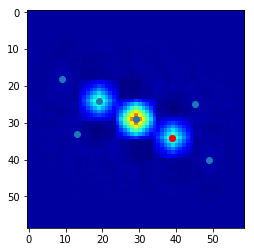

(59, 59)


In [26]:
sq = make_squares()
find_correlation(sq)



(30, 30)


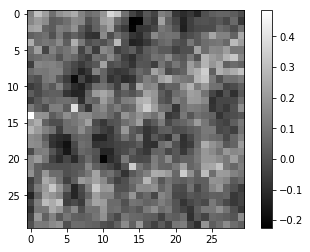

(14, 14)


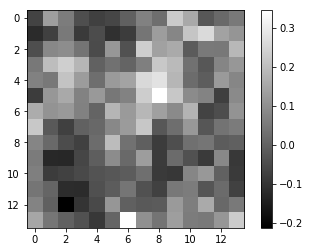

-------  30 ----------


# local peaks 7
[0.007948918, 0.007948918, 0.008362231, 0.008362232, 0.01317416, 0.01317416, 0.033806395]
Peaks: 0.01317416 0.01317416
Vec (y,x): (0, 6)
Amp: 6.0
Corr: 0.01317416


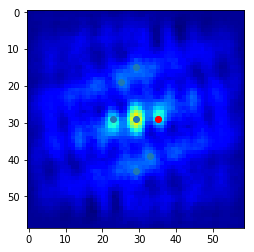

(59, 59)
Amp 30 res:  6.0827627
-------  15 ----------


# local peaks 7
[0.00068777247, 0.0006877725, 0.00073696126, 0.0007369613, 0.0017964573, 0.0017964576, 0.0061966474]
Peaks: 0.0017964576 0.0017964573
Vec (y,x): (-1, 5)
Amp: 5.0990195135927845
Corr: [0.00179646]


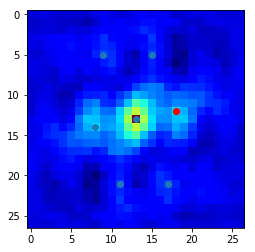

(27, 27)
Amp 15 res:  5.0


In [27]:
cx = 450
cy = 200
frame = 115

amp15 = amp_w15[frame-1]
amp30 = amp_w30[frame-1]
image = images[frame-1]



w = 30
im1 = image[cy-int(w/2):cy+int(w/2), cx-int(w/2): cx+int(w/2)]

print (im1.shape)
plt.imshow(im1, cmap='gray')
plt.colorbar()
plt.show()

w = 15
im2 = image[cy-int(w/2):cy+int(w/2), cx-int(w/2): cx+int(w/2)]

print (im2.shape)
plt.imshow(im2, cmap='gray')
plt.colorbar()
plt.show()

print('-------  30 ----------')
find_correlation(im1)
print('Amp 30 res: ', amp30[cy,cx])


print('-------  15 ----------')
find_correlation(im2)
print('Amp 15 res: ', amp15[cy,cx])



In [25]:
 # My
print('=============================================')
print('=============================================')
#x, y, amp, c = select_peak(my_corr, inds[0], inds[1], values)


In [18]:
w = 1024 / 4
h = 512 / 2

w = 64
h = 64
r = 16

buffers = 2

float_size = 4

print('Image: ', int(w),'x',int(h))
print('Memory needed', w*h*r*r*buffers*float_size / (1024 * 1024), 'MB')
print(w*r)

Image:  64 x 64
Memory needed 8.0 MB
1024


In [88]:
# Proccessing time calculation
frames = 40
shots = 5
t = 5
processors = 35

print(frames*shots, 'images')
print(frames*shots*t / processors, 'min')

200 images
28.571428571428573 min


In [77]:
14*24

336

Real time

In [85]:
print(2050/(frames*shots))

10.25


In [86]:
print(2050/60)

34.166666666666664
